In [6]:
import timeit
from deserialization_hacks import branch_to_array
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

In [2]:
rootfile = "user.nihartma.22884623.EXT0._000001.DAOD_PHYSLITE.test.pool.root"

In [3]:
f = uproot.open(rootfile)

In [4]:
f.file.compression

ZLIB(5)

In [5]:
def read_branch(rootfile, branchname, custom=False, decompress_only=False):
    with uproot.open(rootfile) as f:
        branch = f["CollectionTree"][branchname]
        if decompress_only:
            def decompress():
                for i in range(branch.num_baskets):
                    basket_data = branch.basket(i).data
            return timeit.timeit(decompress, number=1)
        elif custom:
            return timeit.timeit(lambda: branch_to_array(branch), number=1)
        else:
            return timeit.timeit(lambda: branch.array(), number=1)

In [7]:
with open("root_reading_benchmark.json") as json_file:
    root_results = json.load(json_file)

In [9]:
times = []
labels_branches = [
    ("<vector<vector<int>> (Jets)", "AnalysisJetsAuxDyn.NumTrkPt500"),
    ("<vector<vector<ElementLink> (Electrons)", "AnalysisElectronsAuxDyn.trackParticleLinks"),
    ("<vector<vector<vector<char>>> (MET)", "METAssoc_AnalysisMETAux.overlapIndices")
]
df = []
for label, branch_name in labels_branches:
    d = {"label" : label}
    # record second time (read from page cache, jitted numba function)
    read_branch(rootfile, branch_name)
    d["Uproot default"] = read_branch(rootfile, branch_name)
    read_branch(rootfile, branch_name, custom=True)
    d["Custom deserialization"] = read_branch(rootfile, branch_name, custom=True)
    read_branch(rootfile, branch_name, decompress_only=True)
    d["Only decompression"] = read_branch(rootfile, branch_name, decompress_only=True)
    d["ROOT TTree::Draw"] = root_results[branch_name]
    df.append(d)
df = pd.DataFrame(df)

In [13]:
df.to_json("reading_benchmark_all.json")

In [15]:
df

,label,Uproot default,Custom deserialization,Only decompression,ROOT TTree::Draw
0,<vector<vector<int>> (Jets),4.036087,0.056698,0.030301,0.391722
1,<vector<vector<ElementLink> (Electrons),23.346487,0.004348,0.002514,0.055878
2,<vector<vector<vector<char>>> (MET),1.273863,0.105900,0.002086,0.135029


In [10]:
read_branch(rootfile, "AnalysisJetsAuxDyn.pt")
time_vector_float = read_branch(rootfile, "AnalysisJetsAuxDyn.pt")

In [14]:
time_vector_float

0.007419526999001391

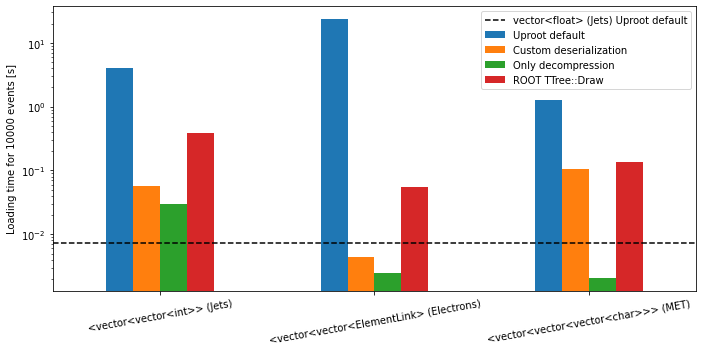

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
df.set_index("label").plot(kind="bar", ax=ax)
ax.tick_params(axis='x', labelrotation=10)
ax.set_xlabel(None)
ax.set_ylabel("Loading time for 10000 events [s]")
ax.set_yscale("log")
ax.axhline(time_vector_float, linestyle="--", color="black", label="vector<float> (Jets) Uproot default")
ax.legend()
fig.tight_layout()
fig.savefig("loading_times.pdf")